In [1]:
# Step 1: Install 7z tool
!apt-get install -y p7zip-full

# Step 2: Define archive path and extract to /content/
archive_path = '/content/drive/MyDrive/model/FLIR_ADAS_Thermal_SR.7z'

# Step 3: Extract to /content/
!7z x "{archive_path}" -o/content/ -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/model/                                       1 file, 1498640846 bytes (1430 MiB)

Extracting archive: /content/drive/MyDrive/model/FLIR_ADAS_Thermal_SR.7z
--
Path = /content/drive/MyDrive/model/FLIR_ADAS_Thermal_SR.7z
Type = 7z
Physical Size = 1498640846
Headers Size = 401813
Method = LZMA2:25
Solid = +
Blocks = 1

  0%      1% 129 - FLIR_ADAS_Thermal_SR/test/video- . rame-001552-wmiZctzdb4qqbCS2o.jpg

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [3]:

# Paths for FLIR ADAS dataset
base_path = '/content/FLIR_ADAS_Thermal_SR'
train_folder = os.path.join(base_path, 'train')
test_folder = os.path.join(base_path, 'test')

def load_flir_images(folder_path, target_size=(128,128)):
    images = []
    filenames = sorted(os.listdir(folder_path))
    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size) / 255.0
            images.append(img[..., np.newaxis])
    return np.array(images)

# Load all train and test data
train_hr = load_flir_images(train_folder, target_size=(128,128))
test_hr = load_flir_images(test_folder, target_size=(128,128))

# Prepare SR data: downsample inputs to simulate LR
def prepare_super_resolution_data(images, scale=2):
    inputs = []
    targets = []
    for img in images:
        hr = img.squeeze()
        lr = cv2.resize(hr, (hr.shape[1]//scale, hr.shape[0]//scale))
        lr = cv2.resize(lr, (hr.shape[1], hr.shape[0]))
        inputs.append(lr[..., np.newaxis])
        targets.append(hr[..., np.newaxis])
    return np.array(inputs), np.array(targets)

train_lr, train_hr = prepare_super_resolution_data(train_hr)
test_lr, test_hr = prepare_super_resolution_data(test_hr)

# Split train into train and validation sets
train_lr, val_lr, train_hr, val_hr = train_test_split(train_lr, train_hr, test_size=0.2, random_state=42)

print(f"Train data shape: {train_lr.shape}, {train_hr.shape}")
print(f"Validation data shape: {val_lr.shape}, {val_hr.shape}")
print(f"Test data shape: {test_lr.shape}, {test_hr.shape}")


Train data shape: (11256, 128, 128, 1), (11256, 128, 128, 1)
Validation data shape: (2815, 128, 128, 1), (2815, 128, 128, 1)
Test data shape: (1564, 128, 128, 1), (1564, 128, 128, 1)


In [4]:
# Lightweight Super-Resolution Autoencoder model
input_img = Input(shape=(128, 128, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
model = Model(input_img, x)

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,569 (146.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model with all data
model.fit(train_lr, train_hr, validation_data=(val_lr, val_hr), epochs=30, batch_size=16)
model.save("SRTFLIRADASAE.h5")


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.0074 - val_loss: 0.0017
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/30
704/704 ━━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Evaluation on Whole Test Set:
Average PSNR: 29.14
Average SSIM: 0.8191


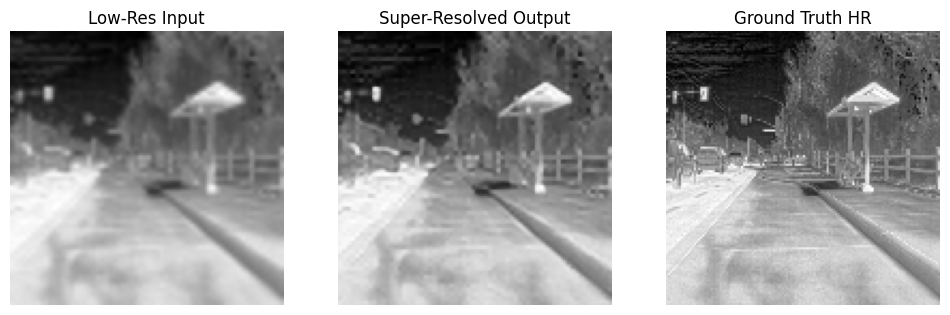

Test Image 1: PSNR=26.29, SSIM=0.7803


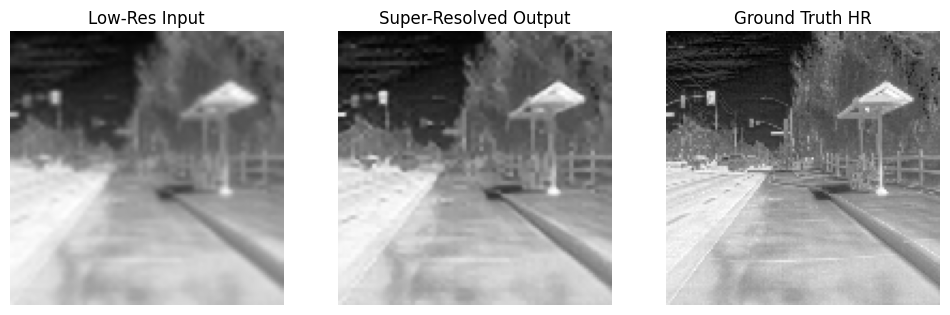

Test Image 2: PSNR=27.26, SSIM=0.7980


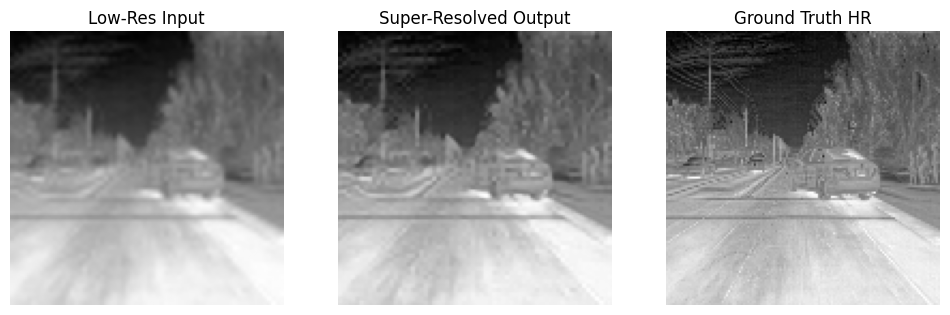

Test Image 3: PSNR=28.30, SSIM=0.7749


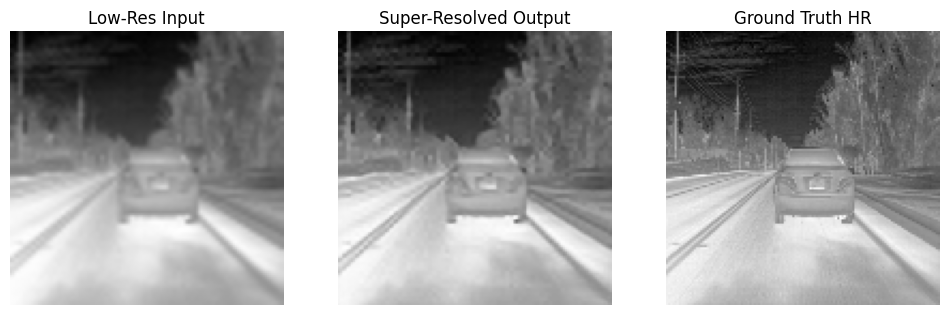

Test Image 4: PSNR=29.58, SSIM=0.8330


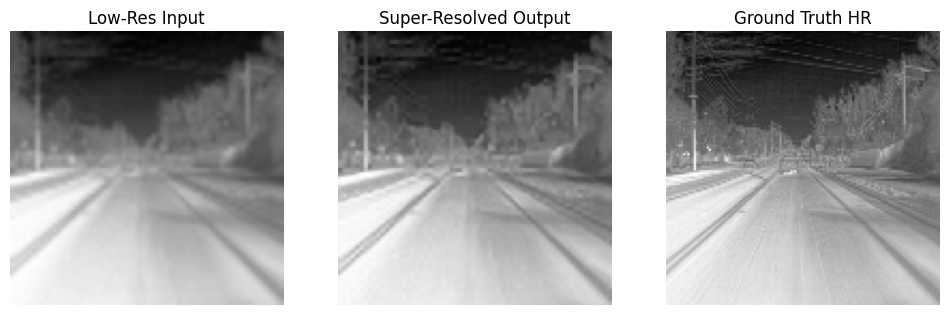

Test Image 5: PSNR=30.40, SSIM=0.8400


In [7]:
# Evaluate PSNR and SSIM on entire Test Set
def evaluate_psnr_ssim(original, reconstructed):
    p = psnr(original.squeeze(), reconstructed.squeeze(), data_range=1.0)
    s = ssim(original.squeeze(), reconstructed.squeeze(), data_range=1.0)
    return p, s

# Predict on the whole Test Set
test_pred = model.predict(test_lr)

# Calculate average PSNR and SSIM for the entire test set
psnr_list = []
ssim_list = []
for i in range(len(test_lr)):
    p, s = evaluate_psnr_ssim(test_hr[i], test_pred[i])
    psnr_list.append(p)
    ssim_list.append(s)

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)

print(f"\nEvaluation on Whole Test Set:")
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Visualize and Evaluate some Test Predictions
for i in range(min(5, len(test_lr))):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(test_lr[i].squeeze(), cmap='gray')
    plt.title("Low-Res Input")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_pred[i].squeeze(), cmap='gray')
    plt.title("Super-Resolved Output")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(test_hr[i].squeeze(), cmap='gray')
    plt.title("Ground Truth HR")
    plt.axis('off')
    plt.show()
    print(f"Test Image {i+1}: PSNR={psnr_list[i]:.2f}, SSIM={ssim_list[i]:.4f}")


In [11]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint
# Build SRCNN model
input_img = Input(shape=(128, 128, 1))
x = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
x = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)
models = Model(input_img, x)

models.compile(optimizer='adam', loss='mse')
models.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Model Checkpoint
checkpoint_path = 'best_srcnn_model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)


In [13]:

# Train the SRCNN model
history = models.fit(train_lr, train_hr,
                    validation_data=(val_lr, val_hr),
                    epochs=30, batch_size=16,
                    callbacks=[checkpoint])


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094
Epoch 1: val_loss improved from inf to 0.00338, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0094 - val_loss: 0.0034
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 2: val_loss improved from 0.00338 to 0.00206, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/30
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019
Epoch 3: val_loss improved from 0.00206 to 0.00172, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/30
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 4: val_loss did not improve from 0.00172
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/30
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 5: val_loss improved from 0.00172 to 0.00162, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 6: val_loss improved from 0.00162 to 0.00160, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 7: val_loss did not improve from 0.00160
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/30
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 8: val_loss improved from 0.00160 to 0.00156, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 9: val_loss improved from 0.00156 to 0.00155, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 10: val_loss improved from 0.00155 to 0.00154, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/30
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 11: val_loss improved from 0.00154 to 0.00153, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 12: val_loss did not improve from 0.00153
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 13/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 13: val_loss improved from 0.00153 to 0.00152, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 14/30
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 14: val_loss did not improve from 0.00152
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 15/30
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 15: val_loss did not improve from 0.00152
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 16/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 16: val_loss improved from 0.00152 to 0.00151, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 17/30
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 17: val_loss did not improve from 0.00151
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 18/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 18: val_loss did not improve from 0.00151
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 19/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 19: val_loss did not improve from 0.00151
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 20/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 20: val_loss did not improve from 0.00151
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 21/30
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 21: val_loss did not improve from 0.00151
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s

704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 23: val_loss did not improve from 0.00149
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 24/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 24: val_loss did not improve from 0.00149
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 25/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 25: val_loss did not improve from 0.00149
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 26/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 26: val_loss did not improve from 0.00149
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 27/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 27: val_loss did not improve from 0.00149
704/704 ━━━━━━━━━━━━━━━━━━━━ 1

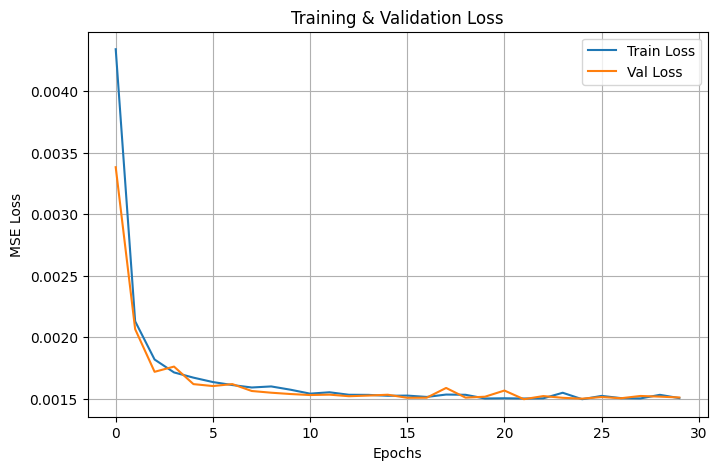

In [14]:
# Plot Training and Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()



49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

Evaluation on Whole Test Set:
Average PSNR: 28.87
Average SSIM: 0.8087


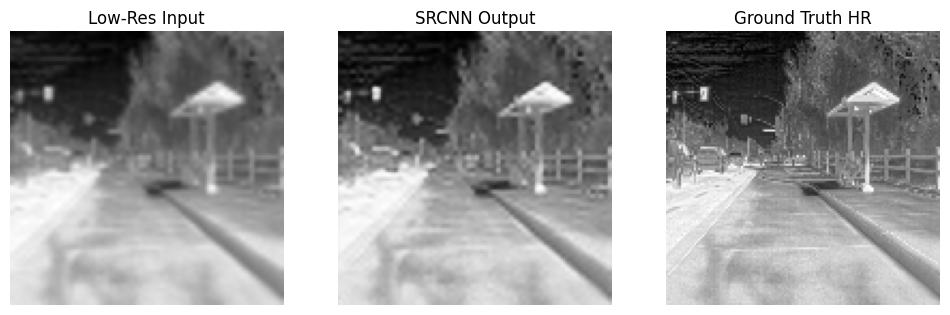

Test Image 1: PSNR=26.12, SSIM=0.7716


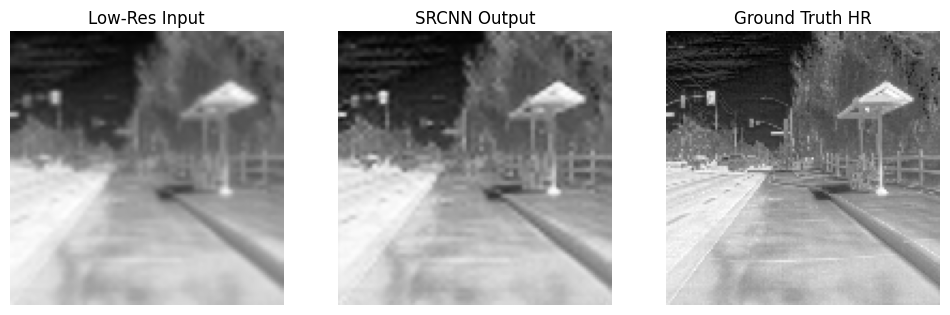

Test Image 2: PSNR=27.03, SSIM=0.7880


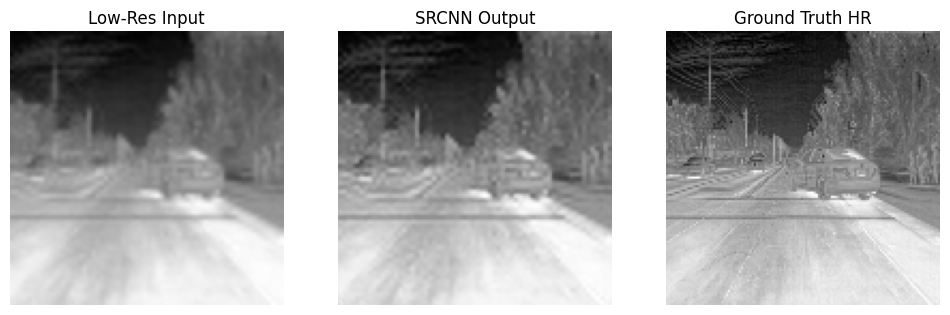

Test Image 3: PSNR=28.07, SSIM=0.7607


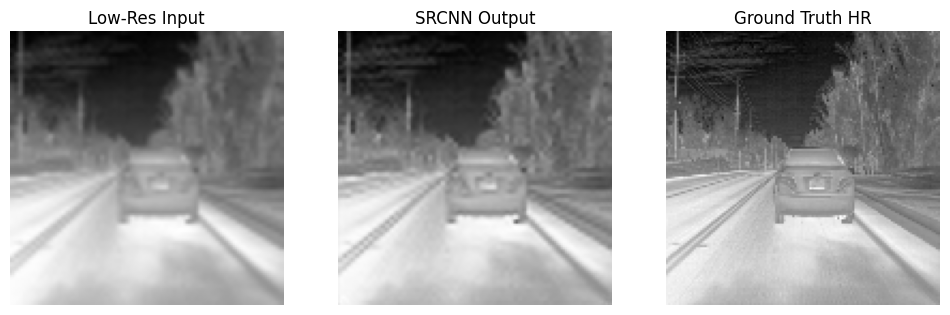

Test Image 4: PSNR=29.30, SSIM=0.8235


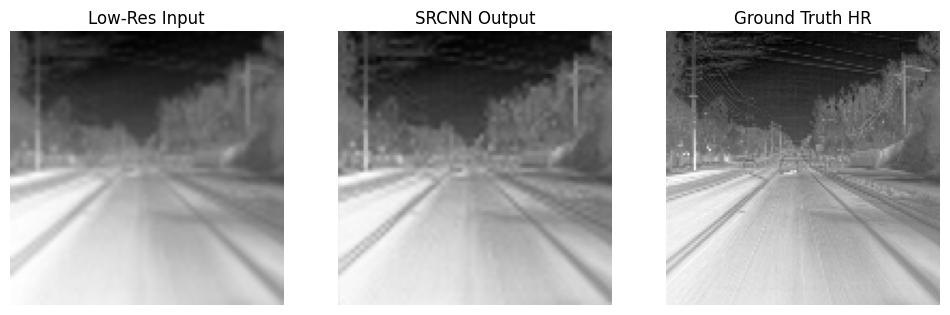

Test Image 5: PSNR=30.06, SSIM=0.8281


In [18]:
# Load the model without compiling
best_model = load_model('/content/best_srcnn_model.h5', compile=False)

# Evaluate PSNR and SSIM on entire Test Set
def evaluate_psnr_ssim(original, reconstructed):
    p = psnr(original.squeeze(), reconstructed.squeeze(), data_range=1.0)
    s = ssim(original.squeeze(), reconstructed.squeeze(), data_range=1.0)
    return p, s

# Predict on the whole Test Set
test_pred = best_model.predict(test_lr)

# Calculate average PSNR and SSIM for the entire test set
psnr_list = []
ssim_list = []
for i in range(len(test_lr)):
    p, s = evaluate_psnr_ssim(test_hr[i], test_pred[i])
    psnr_list.append(p)
    ssim_list.append(s)

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)

print(f"\nEvaluation on Whole Test Set:")
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Visualize and Evaluate some Test Predictions
for i in range(min(5, len(test_lr))):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(test_lr[i].squeeze(), cmap='gray')
    plt.title("Low-Res Input")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_pred[i].squeeze(), cmap='gray')
    plt.title("SRCNN Output")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(test_hr[i].squeeze(), cmap='gray')
    plt.title("Ground Truth HR")
    plt.axis('off')
    plt.show()
    print(f"Test Image {i+1}: PSNR={psnr_list[i]:.2f}, SSIM={ssim_list[i]:.4f}")
